# Task 8 - Issues

### LENI ROBREDO

In [1]:
#install packages
!pip install pyldavis

!pip install streamlit
!pip install pandas-profiling 

## Import Packages

In [2]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel

# import pickle
import pickle

# import wordcloud
from wordcloud import WordCloud

# import pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()


%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


## Reading Files

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def read_file(path):
  df = pd.read_csv(path)
  df = df[~df.lemma_text_flatten.isna()]
  df = df.drop('lemma_text', axis=1)
  df['lemma_text'] = df.lemma_text_flatten.apply(lambda x: [text for text in str(x).split()])
  return df

In [5]:
text_path = '/content/drive/MyDrive/Omdena_Philippines_Politician_Data_data_processed_translated/data_processed_translated.csv'
df = read_file(text_path)
df.head(5)

,date_posted,title,content,candidate,page_url,source,language,text_translated,text_clean,lemma_text_flatten,lemma_text
0,11/22/2021,,"KA LEODY: AYUNGIN SHOAL ATTACK, RESULT OF DUTE...",Leody de Guzman,,Facebook Post,en,"KA LEODY: AYUNGIN SHOAL ATTACK, RESULT OF DUTE...","KA LEODY: AYUNGIN SHOAL ATTACK, RESULT OF DUTE...",leody shoal attack result duterte presence can...,"[leody, shoal, attack, result, duterte, presen..."
1,11/05/2021,,"Paglikha ng DHSUD ng anti-corruption panel, pi...",Greco Belgica,,Facebook Post,en,"Paglikha ng DHSUD ng anti-corruption panel, pi...","Paglikha ng DHSUD ng anti-corruption panel, pi...",paglikha dhsud anticorruption panel pinuri gre...,"[paglikha, dhsud, anticorruption, panel, pinur..."
2,11/07/2021,,"8 Years After 'Yolanda'\n Alang-alang, Leyte -...",Manny Pinol,,Facebook Post,en,"Years After 'Yolanda'\n Alang-alang, Leyte -...","Years After 'Yolanda'\n Alang-alang, Leyte -...",year yolanda eight part story heroism one beau...,"[year, yolanda, eight, part, story, heroism, o..."
3,10/27/2021,,To JOIN the Makakalikasan Party: www.naturepar...,Roy J. Cabonegro,,Facebook Post,en,To JOIN the Makakalikasan Party: www.naturepar...,To JOIN the Makakalikasan Party: www.naturepar...,join makakalikasan party wwwnaturepartyphweebl...,"[join, makakalikasan, party, wwwnaturepartyphw..."
4,11/03/2021,,"ELEAZAR: PNP, DOJ ALREADY WORKING ON ALLEGATIO...",Guillermo Eleazar,,Facebook Post,en,"ELEAZAR: PNP, DOJ ALREADY WORKING ON ALLEGATIO...","ELEAZAR: PNP, DOJ ALREADY WORKING ON ALLEGATIO...",eleazar pnp doj allegation drug operation poli...,"[eleazar, pnp, doj, allegation, drug, operatio..."


#Get the Senatorial candidates data`

In [6]:
vp_candidate = ['Leni Robredo']

In [7]:
def get_candidate_data(vp_candidate_list, df=df):
  df_list = {}
  for candidate in vp_candidate_list:
    candidate_df = df[df.candidate == candidate]
    candidate_df = candidate_df.reset_index(drop=True)
    df_list[candidate] = candidate_df
  return df_list

In [15]:
candidate_data = get_candidate_data(vp_candidate)

robredo_df = candidate_data['Leni Robredo']

## Build LDA Mallet Model

In [9]:
def create_bigrams(texts):
  # Build the bigram model
  bigram = models.Phrases(texts, min_count=5, threshold=100) # higher threshold fewer phrases.

  # Faster way to get a sentence clubbed as a bigram
  bigram_model = models.phrases.Phraser(bigram)

  return [bigram_model[doc] for doc in texts]

In [10]:
def create_trigrams(texts):
  # Build the trigram models
  trigram = models.Phrases(texts, threshold=100)  

  trigram_model = models.phrases.Phraser(trigram)

  return [trigram_model[doc] for doc in texts]

In [11]:
def processed_trigram(text):
  bigram_texts = create_bigrams(text)
  trigram_texts = create_trigrams(bigram_texts)

  return trigram_texts

In [16]:
robredo_texts = processed_trigram(list(robredo_df['lemma_text']))

### Gensim Dictionary and Corpus

In [17]:
def create_dict_corpus(texts):
  dictionary = corpora.Dictionary(texts)
  dictionary.filter_extremes(no_below=5, no_above=0.5)
  corpus = [dictionary.doc2bow(text) for text in texts]
  return dictionary, corpus
  

In [28]:
robredo_dict, robredo_corpus = create_dict_corpus(colmenares_texts)

In [19]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)


In [20]:
def download_mallet():
  !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
  !unzip mallet-2.0.8.zip
download_mallet()

--2021-12-12 06:25:44--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2021-12-12 06:25:44--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  4.88MB/s    in 3.3s    

2021-12-12 06:25:48 (4.71 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

In [21]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [22]:
def build_lda_mallet_model(corpus, id2word, num_topics, alpha, iterations, mallet_path=mallet_path):
  model = models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, alpha=alpha, iterations=iterations)
  return model

In [23]:
def save_model(model, model_name):
  pickle.dump(model, open(f"/content/drive/MyDrive/Omdena Philippines Politician Models Pkl/{model_name}.pkl", "wb"))

In [24]:
def load_model(model_name):
  model = pickle.load(open(f"/content/drive/MyDrive/Omdena Philippines Politician Models Pkl/{model_name}.pkl", "rb"))
  

### Find optimal number of topics

In [25]:
def compute_coherence_scores(corpus, dictionary, texts, num_topics, alpha, iterations, mallet_path=mallet_path):
  model_list = []
  coherence_scores = []
  model = models.wrappers.LdaMallet(mallet_path=mallet_path, 
                                    corpus=corpus, 
                                    num_topics=num_topics,
                                    id2word=dictionary,
                                    alpha= alpha, 
                                    iterations=iterations)

  coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
  
  return coherence_model.get_coherence()

In [26]:
def tune_model(corpus, dictionary, texts):

  # Num of Topics
  num_topics = range(3, 11)

  # Alpha Values
  alpha_vals = list(np.arange(0.1, 1, 0.3))

  # Num of Iterations
  num_iterations = range(150, 400, 50)

  # Topic Threshold
  # topic_threshold_vals = list(np.arange(0.1, 1, 0.2))

  model_results = {
      'num_topics':[],
      'alpha': [],
      'iterations': [],
      # 'topic_threshold': [],
      'coherence_score': []
  }

  for num_topic in num_topics:
    for alpha_val in alpha_vals:
      for iteration in num_iterations:
        # for topic_threshold_val in topic_threshold_vals:
        coherence_score = compute_coherence_scores(corpus, 
                                                    dictionary, 
                                                    texts, 
                                                    num_topic, 
                                                    alpha_val, 
                                                    iteration) # , topic_threshold_val
        
        model_results['num_topics'].append(num_topic)
        model_results['alpha'].append(alpha_val)
        model_results['iterations'].append(iteration)
        #model_results['topic_threshold'].append(topic_threshold_val)
        model_results['coherence_score'].append(coherence_score)
  
  return pd.DataFrame(model_results)

In [29]:
robredo_tuned_df = tune_model(robredo_corpus, robredo_dict, robredo_texts)

Streaming output truncated to the last 5000 lines.
1	0.01429	president vice election senator candidate statement duterte aspirant ferdinand_bongbong_marcos drug manila philippine people poll mayor robredo sen city administration country 
2	0.01429	president leni robredo country vice filipino philippine government time people sector group year part program community power development change world 
3	0.01429	leni admin robredo city today visit team day morning time cong aikarobredo yesterday night jillrobredo brgy support area hour people 
4	0.01429	covid number people today health leni case day service program robredo filipino year plan government country job support senator november 
5	0.01429	route admin leni robredo stop center city today frontliners hospital service_health_worker tomorrow schedule morning reverse mrt service bus yesterday day 
6	0.01429	vice president election candidate robredo campaign people support medium city year leni survey senator post interview member presid

In [30]:
robredo_tuned_df.head()

,num_topics,alpha,iterations,coherence_score
0,3,0.1,150,0.451824
1,3,0.1,200,0.536724
2,3,0.1,250,0.484451
3,3,0.1,300,0.511371
4,3,0.1,350,0.540429


In [31]:
def plot_num_topics(df):
  plt.figure(figsize=(8, 5))
  sns.lineplot(data=df, x='num_topics', y='coherence_score')

In [32]:
robredo_best_model = build_lda_mallet_model(robredo_corpus, robredo_dict, 3, 0.1, 150)

Mallet LDA: 3 topics, 2 topic bits, 11 topic mask
Data loaded.
max tokens: 232
total tokens: 62214
<10> LL/token: -7.91955
<20> LL/token: -7.74414
<30> LL/token: -7.64952
<40> LL/token: -7.55739

0	0.03333	president vice people country government philippine year robredo election leni day support program filipino plan part candidate month job senator 
1	0.03333	president vice robredo leni election city people candidate senator statement time campaign duterte aspirant leader day country mayor year filipino 
2	0.03333	leni admin robredo route today city day center stop cong morning time aikarobredo frontliners support visit team yesterday people partner 

<50> LL/token: -7.51431
<60> LL/token: -7.4787
<70> LL/token: -7.45616
<80> LL/token: -7.44501
<90> LL/token: -7.43815

0	0.03333	people country leni government president robredo year vice program philippine filipino day plan job support part service administration work life 
1	0.03333	president vice election robredo candidate leni city 

In [33]:
robredo_tuned_df[robredo_tuned_df.num_topics ==3].sort_values(by='coherence_score', ascending=False).head()

,num_topics,alpha,iterations,coherence_score
13,3,0.7,300,0.546467
11,3,0.7,200,0.541404
4,3,0.1,350,0.540429
7,3,0.4,250,0.540054
14,3,0.7,350,0.538596


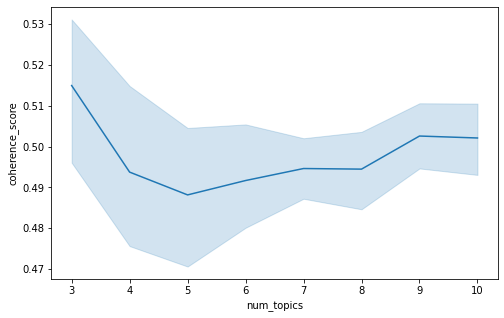

In [34]:
plot_num_topics(robredo_tuned_df)

In [35]:
robredo_df.shape

(6459, 11)

In [36]:
save_model(robredo_best_model, 'robredo_tuned_model')

In [38]:
candidate_models = []
vp_candidate_names = ['robredo_tuned_model']

for candidate_name in vp_candidate_names:
  candidate_model = load_model(candidate_name)
  candidate_models.append(candidate_model)
candidate_models

[None]

## Topic Understanding

### Find topic in each document

In [39]:
def display_topics(model):
  topics = [[(term, round(wt, 3)) for term, wt in model.show_topic(n, topn=20)] for n in range(0, model.num_topics)]
  
  # set column width
  pd.set_option('display.max_colwidth', -1)
  topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Words per Topic'], index=['Topic_'+str(t) for t in range(1, model.num_topics+1)] )
  return topics_df

In [40]:
robredo_df_topic = display_topics(robredo_best_model)

In [41]:
def display_wordcloud(df_topic, rows, cols, fig_size):

  # initiate wordcloud object
  wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

  # set the figure size
  plt.rcParams['figure.figsize'] = fig_size

  # Create subplots for each topic
  for i in range(df_topic.shape[0]):

      wc.generate(text=df_topic["Words per Topic"][i])
      
      plt.subplot(rows, cols, i+1)
      plt.imshow(wc, interpolation="bilinear")
      plt.axis("off")
      plt.title(df_topic.index[i])

  plt.show()

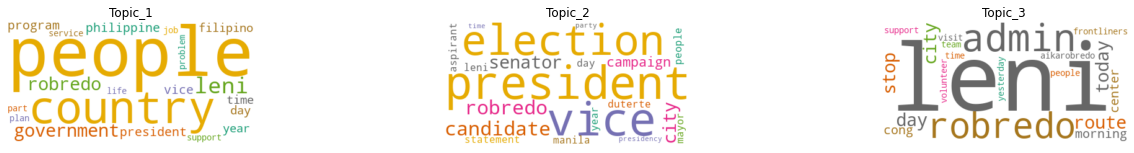

In [44]:
display_wordcloud(robredo_df_topic, 2, 4, [30,5])

### Find Dominant Topic For Each Doc

In [45]:
def create_df_dominant_topic(model, corpus, df_topic, candidate_df):
  vector = model[corpus]
  corpus_topics = [sorted(topic, key=lambda record: -record[1])[0] for topic in vector]

  # create a dataframe
  corpus_topic_df = pd.DataFrame()

  corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
  corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
  corpus_topic_df['Keywords'] = [df_topic.iloc[t[0]]['Words per Topic'] for t in corpus_topics]
  corpus_topic_df['content'] = candidate_df['lemma_text']

  return corpus_topic_df


In [46]:
robredo_dominant_topic = create_df_dominant_topic(robredo_best_model, robredo_corpus, robredo_df_topic, robredo_df)
robredo_dominant_topic.head(15)

,Dominant Topic,Contribution %,Keywords,content
0,2,99.06,"president, vice, election, candidate, robredo, senator, city, campaign, statement, leni, aspirant, people, duterte, mayor, day, manila, year, presidency, time, party","[paggunita, solemnity, christ, paalala, bishop, ambo, david, learn, love, one, another, feel, others, suffering]"
1,3,99.06,"leni, admin, robredo, route, today, city, day, stop, morning, cong, center, aikarobredo, frontliners, visit, volunteer, support, time, team, yesterday, people","[october, covid, case, today, number, philippine, source, department, health]"
2,3,98.69,"leni, admin, robredo, route, today, city, day, stop, morning, cong, center, aikarobredo, frontliners, visit, volunteer, support, time, team, yesterday, people","[honor, leni, robredo, club, makatis, rvote, session]"
3,1,99.34,"people, country, leni, government, robredo, president, program, vice, philippine, filipino, year, time, day, support, job, service, life, part, plan, problem","[excerpt, leni, message, philippine, business, conference, exposition, november, challenge, todayto, reach, help, filipino]"
4,3,97.50,"leni, admin, robredo, route, today, city, day, stop, morning, cong, center, aikarobredo, frontliners, visit, volunteer, support, time, team, yesterday, people","[covid, november, case, today, number, philippine, source, department, health]"
5,3,58.42,"leni, admin, robredo, route, today, city, day, stop, morning, cong, center, aikarobredo, frontliners, visit, volunteer, support, time, team, yesterday, people","[leni, robredo, supporter]"
6,1,99.27,"people, country, leni, government, robredo, president, program, vice, philippine, filipino, year, time, day, support, job, service, life, part, plan, problem","[excerpt, leni, message, pcci, election, stake, peoplethe, life, child, generation]"
7,3,92.80,"leni, admin, robredo, route, today, city, day, stop, morning, cong, center, aikarobredo, frontliners, visit, volunteer, support, time, team, yesterday, people","[covid, november, case, today, number, philippine, source, department, health]"
8,3,99.06,"leni, admin, robredo, route, today, city, day, stop, morning, cong, center, aikarobredo, frontliners, visit, volunteer, support, time, team, yesterday, people","[covid, november, case, today, number, philippine, source, department, health]"
9,1,84.09,"people, country, leni, government, robredo, president, program, vice, philippine, filipino, year, time, day, support, job, service, life, part, plan, problem","[leni, robredo, delivers, philippine, business, conference, exposition, day, recovery]"


### Visualization with pyLDAvis

In [47]:
from gensim.models.ldamodel import LdaModel

def convert_mallet_to_lda(mallet_model):
    lda_model = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics, alpha=mallet_model.alpha) 
    lda_model.state.sstats[...] = mallet_model.wordtopics
    lda_model.sync_state()
    return lda_model

In [48]:
robredo_lda_model = convert_mallet_to_lda(robredo_best_model)

In [49]:
robredo_vis = gensimvis.prepare(robredo_lda_model, robredo_corpus, robredo_dict)

In [51]:
robredo_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.220852  0.059704  1       1        40.966526
0      0.050958 -0.196147  2       1        33.400549
2      0.169894  0.136443  3       1        25.632925, topic_info=           Term         Freq        Total Category  logprob  loglift
2329  admin      750.000000   750.000000   Default  30.0000  30.0000
19    leni       1094.000000  1094.000000  Default  29.0000  29.0000
2474  route      345.000000   345.000000   Default  28.0000  28.0000
16    today      420.000000   420.000000   Default  27.0000  27.0000
20    robredo    966.000000   966.000000   Default  26.0000  26.0000
...       ...           ...          ...       ...      ...      ...
57    community  87.103021    179.443526   Topic3  -5.3168   0.6385 
378   service    83.850215    196.202926   Topic3  -5.3548   0.5112 
150   woman      78.428864    152.956789   Topic3  -5.4217   0.6933 
50    people     97.945723    510.009353   Topic3  -5.1995  -0.2887 
13    number     75.176058    215.482803   Topic3  -5.4640   0.3082 

[215 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1366  2      0.973438  ability  
306   2      0.981937  access   
2329  1      0.027997  admin    
2329  2      0.090656  admin    
2329  3      0.882561  admin    
...  ..           ...    ...    
394   2      0.464059  year     
394   3      0.140875  year     
304   1      0.114377  yesterday
304   2      0.148018  yesterday
304   3      0.733361  yesterday

[275 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])